# Stacked Point-Source Sensitivity

#### Imports

In [1]:
import sources, time
import os, sys, glob, numpy as np, matplotlib, scipy, healpy as hp
from matplotlib import pyplot as plt, colors
from scipy import stats, interpolate, optimize
import numpy.lib.recfunctions as rf

Defined globals

In [2]:
InDataDir = '/i3store/users/mjlarson/ps_tracks'
OutDir = '/condor_builds/blaufuss/stacked_outputs/'
n_trials_bkg = 5000
n_trials_sig = 50

#### Functions

In [3]:
# Write some helper functions that we can use 
# later. Specifically, we want to be able to 
# calculate the angular distance between two
# directions and to produce a trial including
# signal and background.
def to_unit_vector(ra, dec):
    return np.array([np.cos(ra)*np.cos(dec),
                     np.sin(ra)*np.cos(dec),
                     np.sin(dec)])

def angular_distance(ra_A, dec_A, ra_B, dec_B):
    unit_A = to_unit_vector(ra_A, dec_A)
    unit_B = to_unit_vector(ra_B, dec_B)
    if len(unit_A.shape) != 1:
        return np.arccos( np.dot(unit_A.T, unit_B) )
    else:
        return np.arccos( np.dot(unit_A, unit_B) )

In [4]:
# We're going to use a "true" pdf for the signal: 
# We're just going to pick out events that have a
# true direction near to the source. This'll be used
# for when we want to add some signal to our trials
def true_signal_pdf(event, source):
    distance = angular_distance(event['trueRa'], 
                                event['trueDec'], 
                                source['ra'],
                                source['dec'])
    sigma = event['angErr']
    return np.sqrt((1.0)/(2*np.pi*sigma**2)) * np.exp(-(distance)**2/(2*sigma**2))

In [5]:
# A trial is one simulated observation. In our case,
# our analysis is looking at 1000 second time windows
# which may have signal and background events. Define
# a function which can produce a trial for us.
# This time, we want to return the directional info
# for the selected events. To do this, we need to do
# some magic near the end of the function.
def produce_trial(data,
                  sim,
                  n_background,
                  N=0,
                  source = {'ra':np.pi/2, 'dec':np.pi/6},
                  window = 1000,
                  random_seed = None):
    
    if random_seed != None:
        np.random.seed(random_seed)
        
    # We're here going to sample background events from
    # our data. This is a trick we use, since almost all
    # events from our data will be background. This saves
    # us from having to pick a background spectrum.
    n_background_observed = scipy.stats.poisson.rvs(n_background)
    background = np.random.choice(data, n_background_observed)
    if N>0:
        # Use what we know about weighting to pick events
        # from a power law. Here, I'm going to use a power
        # law with an index of -2 and E0 of 100 TeV
        weights = sim['ow'] *\
                  (N * (sim['trueE']/1.e5)**-2) *\
                   window
        weights_sum = np.sum(weights)

        signal_p = true_signal_pdf(sim, source)
        signal_p /= np.sum(signal_p)

        n_signal_observed = scipy.stats.poisson.rvs(weights_sum)
        signal = np.random.choice(sim, n_signal_observed,
                                  p = signal_p)

        # Because we want to return the entire event and not just the
        # number of events, we need to do some numpy magic. Specifically,
        # we need to remove the fields in the simulated events that are
        # not present in the data events. These include the true direction,
        # energy, and 'oneweight'.
        signal = rf.drop_fields(signal, [n for n in signal.dtype.names \
                                         if not n in background.dtype.names])
    else:
        signal = np.empty(0, dtype=background.dtype)
    return np.concatenate([background, signal])

In [6]:
def signal_pdf(event, source):
    
    sigma = event['angErr']
    dist  = angular_distance(event['ra'], event['dec'], source['ra'], source['dec'])
    S     = 1/(2*np.pi*sigma**2)*np.exp(-dist**2/(2*sigma**2))
    
    return S

def background_pdf(event, bg_p_dec):
    return 1/(2*np.pi)*bg_p_dec(np.sin(event['dec']))

In [7]:
def spatial_llh_ratio(events,
                      source,
                      bg_p_dec,
                      ns = 0,
                      minimize = False):
    
    N  = len(events)
    if N==0:
        llh = 0.
        fit_ns = 0.
        return llh, [fit_ns]
    
    if N<ns:
        ns = N
    S = signal_pdf(events, source)
    B = background_pdf(events, bg_p_dec)
    def get_ts(fit_ns):
        ts = np.log(fit_ns/N*(S/B - 1) + 1)
        ts[~np.isfinite(ts)] = 0
        return -1*np.sum(ts)
    
    if minimize:
        results = scipy.optimize.minimize(get_ts, x0 = [ns], bounds = [[0,N]], method = 'SLSQP')
        return -1*results.fun, results.x
    
    else:
        ts = get_ts(ns)
        return -1*ts, [ns]

In [8]:
def produce_n_trials(n_trials,
                     bg_p_dec,
                     data,
                     sim,
                     n_background,
                     ns = 0,
                     N=0,
                     spectrum = -2,
                     E0 = 1e5,
                     source_list = [{'ra':np.pi/2, 'dec':np.pi/6}],
                     window = 1000,
                     random_seed = None, 
                     minimize = False):
    
    if random_seed != None:
        np.random.seed(random_seed)
    
    # Use what we know about weighting to pick events
    # from a power law. Here, I'm going to use a power
    # law with an index of -2 and E0 of 100 TeV
    
    
    signal_ps = []
    weights_sum = 0
    
    # Only calculate weights and true signal pdf if N is not 0
    if N>0:
        weights = sim['ow'] *\
              (N * (sim['trueE']/E0)**spectrum)*window
        weights_sum = np.sum(weights)
        
        # for each source, calculate the true signal pdf
        for source in source_list:
            signal_p = true_signal_pdf(sim, source)
            signal_p /= np.sum(signal_p)
            signal_ps.append(signal_p)
    
    llhs = [0]*n_trials
    
    for i in range(n_trials):
        # We're here going to sample background events from
        # our data. This is a trick we use, since almost all
        # events from our data will be background. This saves
        # us from having to pick a background spectrum.
        
        n_background_observed = scipy.stats.poisson.rvs(n_background)
        background = np.random.choice(data, n_background_observed)
        
        # Only generate signal events if N is not 0
        if N>0:
            n_signal_observed = scipy.stats.poisson.rvs(weights_sum)
            
            # for each source, calculate the llh, and sum them
            for signal_p, source in zip(signal_ps, source_list):
                signal = np.random.choice(sim, n_signal_observed,
                                      p = signal_p)

                # Because we want to return the entire event and not just the
                # number of events, we need to do some numpy magic. Specifically,
                # we need to remove the fields in the simulated events that are
                # not present in the data events. These include the true direction,
                # energy, and 'oneweight'.

                signal = rf.drop_fields(signal, [n for n in signal.dtype.names \
                                                 if not n in background.dtype.names])
                trial   = np.concatenate([background, signal])   
                llhs[i] += spatial_llh_ratio(trial, source, bg_p_dec, ns = ns, minimize = minimize)[0]
        else:
            signal = np.empty(0, dtype=background.dtype)
            trial  = np.concatenate([background, signal])
            
            # for each source, calculate the llh, and sum them
            for source in source_list:
                llhs[i] += spatial_llh_ratio(trial, source, bg_p_dec, ns = ns, minimize = minimize)[0]

    return llhs, spectrum

In [9]:
def percentile_wrapper(percentile, *args, index = 0, **kwargs):
    '''
    description: function used instead of produce_n_trials directly so that memory doesn't fill up while running many 
                 processes. calculates percentile of the results of produce_n_trials.
    
    returns: percentile and spectrum from produce_n_trials, index for updating correct progress bar
    
    parameters:
    percentile: signal percentile to find
    
    *args: arguments for produce_n_trials
    
    index: index for updating correct progress bar
    
    **kwargs: keyword arguments for produce_n_trials
    '''
    ts_dist, spectrum = produce_n_trials(*args, **kwargs)
    return np.percentile(ts_dist, percentile), spectrum, index

In [10]:
def spline_sensitivity(*args,
                       n_trials = (1000,1000),
                       points = np.logspace(-20, -19, 12),
                       percentiles = (50,10),
                       plot = None,
                       save_data = None,
                       spectra = [-2],
                       windows = [1000],
                       n_backgrounds = [340*1000/(24*3600)],
                       split = 1000,
                       **kwargs):
    '''
    description: this function finds the minimum flux normalization that produces a signal+background ts distribution using
                 produce_n_trials such that some given percentile of that distribution is above some given percentile of the
                 background distribution. this function can do this calculation for multiple time windows and multiple
                 spectral indicies, returning a list of flux normalization minima for each possible combination of parameters.
                 
                 to find the minimum, the function finds the percentiles of the signal+background distribution at a range of
                 flux normalizations and generates a spline function over those data points. then the function uses a
                 bisection algorithm to find the minimum.
                 
                 this function is set up for multiprocessing and progress bars using tqdm to show the progress of the calculations
                 
    returns: an ordered list of minimum flux normalizations sorted first by time window, and then by spectral index
    
    function parameters:
    n_trials: tuple of number of background trials and number of signal trials for each set of parameters
    
    points: an array of flux normalizations. should be logspacing. bounds should be the lowest range for parameter space.
            the code will step through flux normalization windows with the same logspacing until the sensitivity is in 
            the window. this will be done independently for each parameter set.
            
    percentiles: tuple of percentile to use for background and for signal. generally 50,10 for sensitivity and 99.97,50
                 for discovery potential.
                 
    plot: if None, do not produce plots. otherwise, should be a string with directory and filename prefix for plot outputs
    
    save_data: if none, do not save data. otherwise, should be a string with directory and filename prefix for data outputs
    
    parallel: int determining how many processes to use
    
    spectra: list of spectral indicies to find sensitivities for
    
    windows: list of time windows (seconds) to find sensitivities for
    
    n_backgrounds: list of expected numbers of background events for each time window
    
    timeout: timeout (seconds) for each process to complete
    
    split: int number of events per process for background trials
    
    **kwargs: keyword arguments for produce_n_trials
    '''
    
    # if the split value is larger than the requested number of background trials, do all the background trials at once 
    split = min(n_trials[0], split)
    
    # generate a list of flux normalization ranges for each parameter set
    sig_points = [np.copy(points) for _ in range(len(spectra)*len(windows))]
    
    # initialize list for minima
    roots = [None for _ in range(len(windows)*len(spectra))]
    
    # loop over each time window
    for j,n_background in enumerate(n_backgrounds):
        
        time_window = windows[j]
        print(f"time window: {windows[j]}s")
        print("running background trials.", end = '')
        bg_trials = []
        for _ in range(n_trials[0]//split):
            bg_trials.append(produce_n_trials(split, *args, N = 0, window = time_window, n_background = n_background, **kwargs)[0])
            print('.', end = '')
        print("done")
        
        bg_ts_dist    = np.concatenate(bg_trials)
        bg_percentile = np.percentile(bg_ts_dist, percentiles[0])
            
        # initialize lists for testing if flux normalization space is correct
        bad_list  = list(range(len(spectra)))    
        sig_percentiles = [None for _ in range(len(points)*len(spectra))]
        
        print(f"searching for flux normalization ranges to use.", end = '')
        # loop to test the flux normalization space for each parameter set
        while len(bad_list) > 0:
            # initialize list to keep track of good flux normalization spaces
            to_remove = []
            
            for i in bad_list:
                # get percentiles and spectral indicies from each parameter set
                test_percentile, spectra_test, _ = percentile_wrapper(percentiles[1], n_trials[1], *args,
                                                                      N = sig_points[len(windows)*i + j][-1], 
                                                                      spectrum = spectra[i], index = i, window = time_window, 
                                                                      n_background = n_background, **kwargs)

                # if the range is too low, increment the range. else, mark the parameter set for
                # removal from the bad list
                if test_percentile <= bg_percentile:
                    sensitivity_in_range = False
                    old_min = np.log10(sig_points[len(windows)*i + j][0])
                    old_max = np.log10(sig_points[len(windows)*i + j][-1])
                    sig_points[len(windows)*i + j] = np.logspace(old_max, 2*old_max - old_min, len(points))
                    print('.', end = '')
                else:
                    sig_percentiles[(i+1)*len(points) - 1] = test_percentile
                    to_remove.append(i)
                    print('!', end = '')

            # remove marked parameter sets
            for i in to_remove: bad_list.remove(i)
        print("done")
        print("running signal + background trials")
        # now that all flux normalization spaces are good, run signal+background trials
        for i, spectrum in enumerate(spectra):
            print(f"spectrum: E^{spectrum:.2f}.", end = '')
            for k, point in enumerate(sig_points[len(windows)*i + j][:-1]):
                sig_percentiles[len(points)*i + k] = percentile_wrapper(percentiles[1], n_trials[1], *args, 
                                                                        N = point, spectrum = spectrum, index = i, 
                                                                        window = time_window, n_background = n_background, 
                                                                        **kwargs)[0]
                print('.', end = '')
            print("done")

        if plot is not None:
            #initialize plots
            fig, axes = plt.subplots(len(spectra), 1, figsize = (10, 6*len(spectra)))
            
        to_save = [None for _ in spectra]
        
        if hasattr(axes, '__len__'):
            ax_list = axes.flatten()
        else:
            ax_list = [axes]
        
        for i, (ax, spectrum) in enumerate(zip(ax_list,spectra)):
            # find all signal percentiles <= background percentile
            occurences = np.where(sig_percentiles[i*len(points):(i+1)*len(points)] <= bg_percentile)[0]
            
            # set the minimum for the bisection as the last item in occurances
            if len(occurences) > 0:
                min_point = occurences[-1]
            else:
                min_point = 0
            
            # calculate the spline
            sig_spline = interpolate.InterpolatedUnivariateSpline(sig_points[len(windows)*i + j], np.array(sig_percentiles[i*len(points):(i+1)*len(points)]) - bg_percentile, ext = 3)
            
            # find the minimum using bisection
            roots[len(windows)*i + j] = bisection_highest_root(sig_spline, [sig_points[len(windows)*i + j][min_point],sig_points[len(windows)*i + j][-1]], precision  = 1e-3*sig_points[len(windows)*i + j][0])
            
            # plot 
            if plot is not None:
                x = np.logspace(np.log10(sig_points[len(windows)*i + j][0]), np.log10(sig_points[len(windows)*i + j][-1]), 100)
                ax.semilogx(sig_points[len(windows)*i + j], sig_percentiles[i*len(points):(i+1)*len(points)], label = 'calculated TS values', linestyle = '', marker = '.')
                ax.semilogx(x, sig_spline(x) + bg_percentile, color = 'C1', label = 'spline interpolation')
                ax.axvline(roots[len(windows)*i + j], linestyle = '--', color = 'k', label = 'sensitivity: N = {:.3e}'.format(roots[len(windows)*i + j]))
                ax.set_xlim(sig_points[len(windows)*i + j][0], sig_points[len(windows)*i + j][-1])
                ax.set_xlabel('flux normalization (N)')
                ax.set_ylabel('signal+background {:}th percentile TS value'.format(percentiles[1]))
                ax.legend()
                ax.set_title(f'E^{spectrum} spectrum')
            
            # add results to array to be saved to a file
            to_save[i] = np.array([spectrum, time_window, roots[len(windows)*i + j], n_trials, sig_points[len(windows)*i + j], percentiles, kwargs, bg_ts_dist])
            # save your results
            if save_data is not None:
                np.save(save_data+time.strftime("%Y%m%d-%H%M%S")+f'tw{time_window}_index{spectrum}.npy', np.array(to_save[i]))
        #Make plots
        if plot is not None:
            plt.savefig(plot+f'tw{time_window}.pdf')
            plt.close()
    print("Roots:",roots)
    return roots

In [11]:
# assumes monotonically increasing function. finds rightmost root.
def bisection_highest_root(f,
                           bounds = [0, 1e-10],
                           precision = 1e-22):
    '''
    description: uses a bisection algorithm to find the point when a monotonically increasing function first becomes > 0
    '''
    x_low,x_high = bounds
    y_low  = f(x_low)
    y_high = f(x_high)
    x_mid  = np.sqrt(x_low*x_high)
    
    while (x_high > precision + x_low):
        x_mid = np.sqrt(x_low*x_high)
        y_mid = f(x_mid)
        
        if y_mid <= 0:
            x_low = x_mid
        else:
            x_high = x_mid
    
    return x_mid

In [12]:
def plot(ts_dist_bg, ts_dist_sig, bins = None):
    '''
    description: this function plots a background distribution and a background+signal distribution
                 with a vertical line at background median and at background+signal 10th percentile
    '''
    background_median = np.percentile(ts_dist_bg, 50)

    # Show these distributions to get a feel for how
    # the two distributions look.
    fig, ax = plt.subplots(figsize=(10, 6))

    if bins is None:
        bins = np.linspace(max(0,min(ts_dist_bg)),
                           max(25,max(ts_dist_sig)),
                           int(max(26, min(50,max(ts_dist_sig)+1 - min(ts_dist_bg)))))

    ax.hist(ts_dist_bg,
           bins = bins,
           color = 'r',
           alpha = 0.6,
           label = 'Background',
           density = True)

    ax.hist(ts_dist_sig,
           bins = bins,
           color = 'b',
           alpha = 0.6,
           label = 'Signal+Background',
           density = True)

    # Let's also directly show the location of the median
    # of the background distribution
    ax.axvline(background_median,
               linewidth=3,
               color = 'k',
               alpha = 0.4,
               linestyle = 'dashed',
               label = r"Background median")

    # We want 90% of the (signal+background) to be
    # above the sensitivity, but np.percentile takes
    # the percentage *below* instead.
    signal_10pc = np.percentile(ts_dist_sig, 10)
    ax.axvline(signal_10pc,
               linewidth=3,
               color = 'k',
               alpha = 0.4,
               linestyle = 'dotted',
               label = "Signal 10%")


    ax.legend(fontsize=16)
    ax.grid(alpha=0.2)
    ax.set_xlabel("Test Statistic", fontsize=16)
    ax.set_ylabel("Number of trials", fontsize=16,)
    ax.tick_params(which="both", labelsize=14)
    plt.show()

#### Computation

In [13]:
# Load in both the simulation and the data
sim = np.load(InDataDir + "/IC86_2012_MC.npy")
data = np.load(InDataDir + "/IC86_2012_exp.npy")

# Reduce simulation size
N = len(sim) 
n_keep = 100000
sim = np.random.choice(sim,size = n_keep,replace = False) # reduce to 10k events
sim['ow'] /= float(n_keep)/float(N) # correct the weights
print("Reduced the number of simulation events from ",
      "{} to {}".format(N, len(sim)))

# Show the possible keys available here:
print("Keys available in simulation:")
print(sorted(sim.dtype.names))
print()

print("Keys available in data:")
print(sorted(data.dtype.names))

Reduced the number of simulation events from  11595414 to 100000
Keys available in simulation:
['angErr', 'azi', 'dec', 'event', 'logE', 'ow', 'ra', 'run', 'subevent', 'time', 'trueDec', 'trueE', 'trueRa', 'zen']

Keys available in data:
['angErr', 'azi', 'dec', 'event', 'logE', 'ra', 'run', 'subevent', 'time', 'zen']


In [14]:
# Also load in the "GoodRunList" (GRL), a file that tells
# us when the detector was taking good data. 
grl = np.load(InDataDir + "/GRL/IC86_2012_exp.npy")

# Show the keys available in the GRL
print("Keys available in the GoodRunList:")
print(sorted(grl.dtype.names))

Keys available in the GoodRunList:
['events', 'livetime', 'run', 'start', 'stop']


In [15]:
# We will need the average rate for our analysis.
# We can get this by either counting the number of
# events in data or the number of events recorded
# in the GRL and dividing by the total good livetime.
total_events = len(data)
total_livetime = np.sum(grl['livetime'])

average_rate = total_events / total_livetime
print("Data has an average rate of {:4.2f} events/day".format(average_rate))

Data has an average rate of 339.96 events/day


In [16]:
# Define the parameters of our analysis.
# We're going to simplify things a little bit to start
# and ignore the impact of detector downtime, which
# would need to be included in an actual analysis.
# 
# Our first test analysis will look for an excess of 
# neutrino events in 1000 seconds across the entire sky.
time_window = 1000 # seconds
time_window /= (24*3600.) # converted to days, since our rate is in days.

# We will be using the data to model the background in
# our test analysis. How many background events should
# we expect in our analysis?
n_expected = average_rate * time_window
print("We expect an average of {:4.3f} background events in our "\
      "{:4.3f} day time window.".format(n_expected, time_window))

We expect an average of 3.935 background events in our 0.012 day time window.


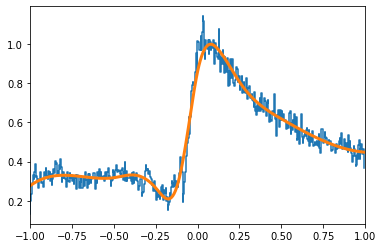

In [17]:
bins      = np.linspace(-1,1,500)
bg_hist,_ = np.histogram(np.sin(data['dec']), bins = bins, density = True)
bg_p_dec  = interpolate.UnivariateSpline(bins[:-1]+np.diff(bins)/2, bg_hist, s = 1, ext = 3)

fig,ax = plt.subplots()
ax.plot(bins[:-1], bg_hist, drawstyle = 'steps')
ax.plot(bins[:-1]+np.diff(bins)/2, bg_p_dec(bins[:-1]+np.diff(bins)/2), linewidth = 3)
ax.set_xlim([-1,1])
plt.show()

In [18]:
# get sources from source file
source_list = [sources.crab_nebula, sources.txs, sources.m77, sources.mgro1908, sources.sag_a_star, sources.mag_l, sources.mag_s]

In [19]:
# this is to suppress the log warnings from the llh calculations
import warnings
warnings.filterwarnings('ignore')

# define parameter space
time_windows = np.array([100])
spectra = np.array([-3.5])
#time_windows = np.logspace(1,6,6)
#spectra = np.linspace(-3.5,-1,6)

# run sensitivity analysis
roots = spline_sensitivity(bg_p_dec,
                           data,
                           sim,
                           n_trials = (n_trials_bkg,n_trials_sig), 
                           ns = 1, 
                           source_list = source_list, 
                           minimize = True,
                           plot = OutDir + 'sensitivity_',
                           save_data = OutDir,
                           windows = time_windows,
                           n_backgrounds = average_rate*time_windows/(24*3600),
                           spectra = spectra)

# Just printing this out for sanity checking, not used
s = np.reshape(roots, (-1, len(time_windows)))
for i,window in enumerate(time_windows):
    s[i:] *= 1e10*window
print(s)

time window: 100s
running background trials......done
searching for flux normalization ranges to use....!done
running signal + background trials
spectrum: E^-3.50............done
Roots: [4.329646256227551e-17]
[[4.32964626e-05]]


#### Plotting - Let's read the output from disk and make pretty pictures.

In [20]:
#run this block if you want to plot from saved data and not from s directly

import glob
filenames = glob.glob(OutDir + '*.npy')

#time_windows = np.logspace(1,6,6)
#spectra = np.linspace(-3.5,-1,6)

loaded = []
for file in sorted(filenames):
    loaded.append(np.load(file, allow_pickle = True))    
s = []
for entry in loaded:
    # each entry has [index, timewindow, flux norm]
    print(entry[0], entry[1], entry[2]*1e10*entry[1])
    s.append([entry[0], entry[1], entry[2]*1e10*entry[1]])
sarray = np.array(s)
# Make a list of unique spectral indices
idxs = np.unique(sarray[:,0])
# split out the TW and time int. flux limits for each
foo = np.array( [list(sarray[sarray[:,0]==i,1:]) for i in idxs] )
# zip with spectral indices fo easy plotting
IndexSplitTWLimits = np.array(list(zip(idxs, foo)))
print(IndexSplitTWLimits)


-1.0 10.0 0.00015206103187059817
-1.5 10.0 0.002310956261526098
-2.0 10.0 0.005337517489337915
-2.5 10.0 0.002310956261526098
-3.0 10.0 0.0002848909294898823
-3.5 10.0 2.8489092948988232e-05
-1.0 100.0 0.00018745836704065248
-1.5 100.0 0.002310956261526098
-2.0 100.0 0.005337517489337916
-2.5 100.0 0.002310956261526098
-3.0 100.0 0.00035120890454244625
-1.0 1000.0 0.00023848639065530782
-1.5 1000.0 0.003701910875675016
-2.0 1000.0 0.005337517489337915
-2.5 1000.0 0.0018745836704065245
-3.0 1000.0 0.0005337517489337916
-3.5 1000.0 3.512089045424478e-05
-1.0 10000.0 0.00015101554764869224
-1.5 10000.0 0.002848909294898812
-2.0 10000.0 0.004329646256227551
-2.5 10000.0 0.001858273152966191
-3.0 10000.0 0.00035120890454244777
-3.5 10000.0 4.314736505224319e-05
-1.0 100000.0 0.0001853152005856746
-1.5 100000.0 0.001956008504131679
-2.0 100000.0 0.004374126464966697
-2.5 100000.0 0.0023831582195543177
-3.0 100000.0 0.0001951216220984148
-3.5 100000.0 1.9528123426944626e-05
-1.0 1000000.0 0.0

-3.5 [1.e+01 1.e+02 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06] [1.95281234e-05 2.84890929e-05 3.51208905e-05 3.51208905e-05
 4.31473651e-05 4.32964626e-05 1.00056231e-04]
-3.0 [1.e+01 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06] [0.00019512 0.00028489 0.00035121 0.00035121 0.00053375 0.00068855]
-2.5 [1.e+01 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06] [0.00185827 0.00187458 0.00231096 0.00231096 0.00238316 0.00325043]
-2.0 [1.e+01 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06] [0.00432965 0.00437413 0.00533752 0.00533752 0.00533752 0.01098428]
-1.5 [1.e+01 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06] [0.00195601 0.00231096 0.00231096 0.00284891 0.00370191 0.00724504]
-1.0 [1.e+01 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06] [0.00015102 0.00015206 0.00018532 0.00018746 0.00023849 0.0004081 ]


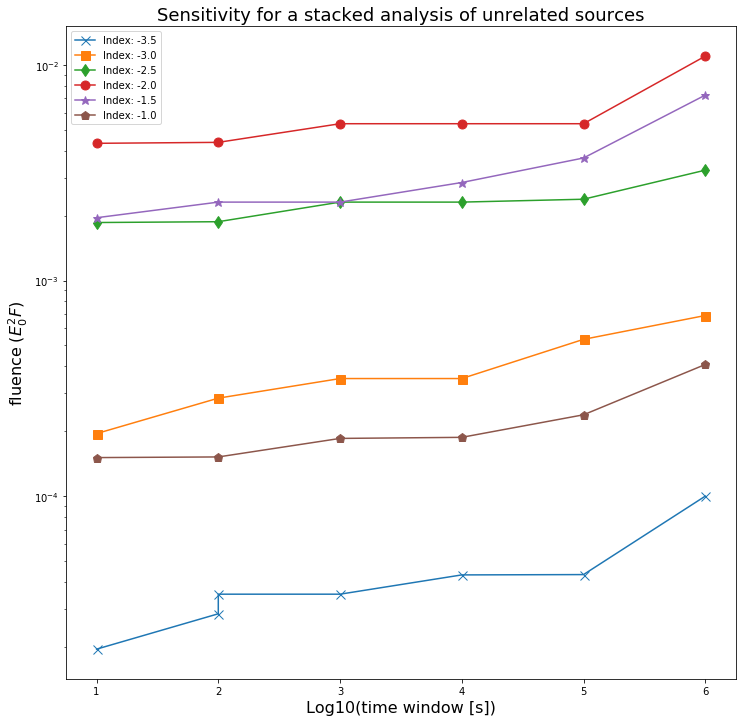

In [21]:
fig, ax = plt.subplots(figsize = (12,12))
import itertools
marker = itertools.cycle(('x', 's', 'd', 'o', '*', 'p', '3')) 
# plot a line per spectral index
for entry in IndexSplitTWLimits:
    idx = entry[0]
    tw_limits = np.array(entry[1])
    np.ndarray.sort(tw_limits,axis=0)
    print(idx, tw_limits[:,0],tw_limits[:,1])
    labeled = 'Index: ' + str(idx)
    plt.plot(np.log10(tw_limits[:,0]),tw_limits[:,1],label=labeled, marker=next(marker), markersize = 9)
ax.set_yscale('log')
ax.set_title('Sensitivity for a stacked analysis of unrelated sources', fontsize = 18)
ax.set_xlabel('Log10(time window [s])', fontsize = 16)
ax.set_ylabel(f'fluence ($E_0^2F$)', fontsize = 16)
leg = ax.legend();
plt.savefig(OutDir + 'results.pdf')